In [1]:
from keras import models, layers
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import load_model
 
 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_dir = os.path.join('./Dataset/Train')
val_dir = os.path.join('./Dataset/Validation')
test_dir = os.path.join('./Dataset/Test')

In [2]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(220, 200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(220, 200), color_mode='rgb')

input_tensor = Input(shape=(220, 200, 3), dtype='float32', name='input')

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [3]:
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(220, 200, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 220, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 220, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 220, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 110, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 110, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 110, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 55, 50, 128)       0     

In [4]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(2, activation='sigmoid'))


additional_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              75501568  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 100,707,138
Trainable params: 85,992,450
Non-trainable params: 14,714,688
__________________________________

In [5]:
checkpoint = ModelCheckpoint(filepath='pretrained_VGG_weight.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)
 
additional_model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])


history = additional_model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=10, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
10000/10000 [==============================] - 906s 91ms/step - loss: 0.1791 - acc: 0.9327 - val_loss: 0.2340 - val_acc: 0.9330
Epoch 2/10
10000/10000 [==============================] - 844s 84ms/step - loss: 0.1490 - acc: 0.9498 - val_loss: 0.2418 - val_acc: 0.9323
Epoch 3/10
10000/10000 [==============================] - 839s 84ms/step - loss: 0.1357 - acc: 0.9555 - val_loss: 0.1817 - val_acc: 0.9517
Epoch 4/10
10000/10000 [==============================] - 838s 84ms/step - loss: 0.1276 - acc: 0.9591 - val_loss: 0.2001 - val_acc: 0.9455
Epoch 5/10
10000/10000 [==============================] - 836s 84ms/step - loss: 0.1204 - acc: 0.9623 - val_loss: 0.1845 - val_acc: 0.9392
Epoch 6/10
10000/10000 [==============================] - 836s 84ms/step - loss: 0.1123 - acc: 0.9651 - val_loss: 0.2042 - val_acc: 0.9449
Epoch 7/10
10000/10000 [==============================] - 845s 84ms/step - loss: 0.1067 - 

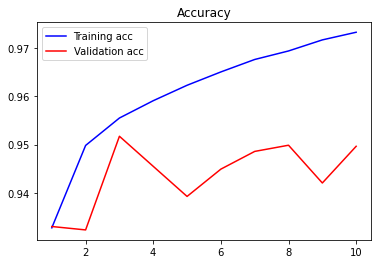

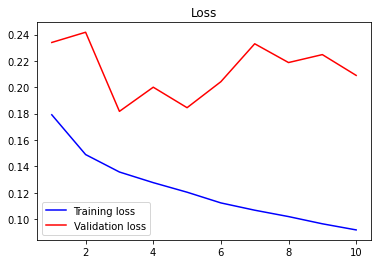

In [6]:
# number of train & validation samples 
# print(train_generator.n)
# print(val_generator.n)
 
# number of train & val batch_size
# print(train_generator.batch_size)
# print(val_generator.batch_size)
 
 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [3]:
additional_model = load_model('pretrained_VGG_weight.hdf5')

In [4]:
test_set = test_datagen.flow_from_directory(test_dir,target_size=(220, 200),batch_size=3,class_mode='binary')

Found 20001 images belonging to 2 classes.


In [5]:
output = additional_model.predict_generator(test_set, steps=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [6]:
output

array([[9.9992061e-01, 1.0579181e-04],
       [9.9901712e-01, 1.1237320e-03],
       [1.0000000e+00, 1.7488474e-36]], dtype=float32)

In [63]:
import cv2
import numpy as np

for i in range(len(output)):
    print(i)
    img = cv2.imread
    if output[0][i] > 0.9:
        print("등록된 사진은 남자.", "확률:", output[0][i]*100)
        cv2.imshow('a',output[i])
    else:
        print("등록된 사람과 일치하지 않으므로 재 등록 바람.", "확률:", (1-output[0][i])*100)

0
등록된 사진은 남자. 확률: 96.70009016990662
1
등록된 사람과 일치하지 않으므로 재 등록 바람. 확률: 96.10161483287811
2


IndexError: index 2 is out of bounds for axis 0 with size 2

In [48]:
output[1][2]

IndexError: index 2 is out of bounds for axis 0 with size 2